In [270]:
import os
import sys
import importlib
AbsPath = str(os.path.abspath(""))+"/../.."
sys.path.append(AbsPath)
import numpy as np
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from Functions import Functions as F
import colossus.halo.mass_adv as massdefs
from colossus.cosmology import cosmology
from colossus.lss import mass_function
cosmology.setCosmology("planck15")
Cosmo =cosmology.getCurrent()
h = Cosmo.h
h_3 = h*h*h

#set plot paramaters here
mpl.rcParams.update(mpl.rcParamsDefault)
plt.rcParams['ytick.minor.visible']=True
plt.rcParams['xtick.minor.visible']=True
plt.rcParams['axes.linewidth']=2
plt.rcParams['xtick.major.size'] = 5
plt.rcParams['ytick.major.size'] = 5
plt.rcParams['xtick.minor.size'] = 3
plt.rcParams['ytick.minor.size'] = 3
plt.rcParams['xtick.major.width'] = 1
plt.rcParams['ytick.major.width'] = 1
plt.rcParams['xtick.minor.width'] = 1
plt.rcParams['ytick.minor.width'] = 1
mpl.rcParams['axes.titlepad'] = 20

plt.rcParams['font.size']=15

/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:886: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:855: MatplotlibDeprecationWarning: 
examples.directory is deprecated; in the future, examples will be found relative to the 'datapath' directory.
  "found relative to the 'datapath' directory.".format(key))
/home/pg1g15/anaconda3/lib/python3.6/site-packages/matplotlib/__init__.py:846: MatplotlibDeprecationWarning: 
The text.latex.unicode rcparam was deprecated in Matplotlib 2.2 and will be removed in 3.1.
  "2.2", name=key, obj_type="rcparam", addendum=addendum)


In [4]:
from Scripts import SMHM_Fit_MCMC
HMF_Class = SMHM_Fit_MCMC.HaloMassFunction()

In [214]:
SubHalosByAcc = HMF_Class.SHMF_STEEL(0.104)
#DM_Masses = (massdefs.changeMassDefinitionCModel(np.power(10, SubHalosByAcc[0]+np.log10(h)), 0.1, "vir", "200m")[0], SubHalosByAcc[1], SubHalosByAcc[2])
#DM_Masses = np.power(10, SubHalosByAcc[0]+np.log10(h)) #M h-1
DM_Masses =massdefs.changeMassDefinitionCModel(np.power(10, SubHalosByAcc[0]+np.log10(h)), 0.1, "vir", "200m")[0]
CentralHalos = mass_function.massFunction(DM_Masses, 0.1, mdef = "200m", model = 'tinker08', q_out='dndlnM')*np.log(10) #h^3 Mpc^-3 dex-1

In [77]:
print(np.shape(SubHalosByAcc[0]))
print(np.shape(SubHalosByAcc[1]))
print(np.shape(SubHalosByAcc[2]))

(65,)
(190, 65)
(190,)


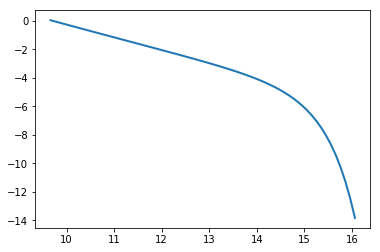

In [108]:
plt.plot(np.log10(DM_Masses), np.log10(CentralHalos))

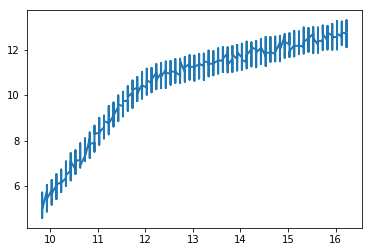

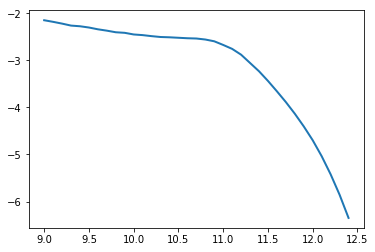

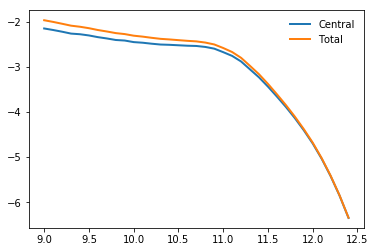

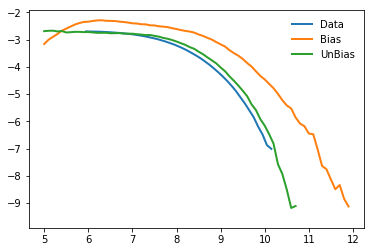

In [136]:
SMF_Bin = 0.1
HMF_Bin = 0.1
SMF_X = np.arange(9, 12.5, SMF_Bin)

M10, SHMnorm10, beta10, gamma10,M11,SHMnorm11,beta11,gamma11, Scatter = 11.925, 0.032,1.639,0.532,0.576,-0.014,-0.693,0.03,0.15
z = 0.1
zparameter = np.divide(z-0.1, z+1)
#putting the parameters together for inclusion in the Moster 2010 equation
M = M10 + M11*zparameter
N = SHMnorm10 + SHMnorm11*zparameter
b = beta10 + beta11*zparameter
g = gamma10 + gamma11*zparameter

DM = SubHalosByAcc[0]
Wt = CentralHalos

N_rep = 5000

DM = np.repeat(SubHalosByAcc[0], N_rep) #log Mh [Msun]
Wt = np.repeat(np.divide(CentralHalos*h_3*HMF_Bin, N_rep), N_rep) #Phi/N [Mpc^-3]

SM = np.log10(np.power(10, DM) * (2*N*np.power( (np.power(np.power(10,DM-M), -b) + np.power(np.power(10,DM-M), g)), -1))) + np.random.normal(0, Scatter, size = np.shape(DM))
plt.plot(DM, SM)
plt.show()
SMF_Total = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin)-(SMF_Bin/2), weights = Wt, density = False)[0]

plt.plot(SMF_X, np.log10(np.divide(SMF_Total, SMF_Bin)))
plt.show()


SMF_Central = SMF_Total

for i, z in enumerate(SubHalosByAcc[2]):
    #print(z)
    Wt = np.repeat(np.divide(SubHalosByAcc[1][i]*h_3*HMF_Bin, N_rep ), N_rep) #Phi/N [Mpc^-3]
    #print(Wt)
    zparameter = np.divide(z-0.1, z+1)
    #putting the parameters together for inclusion in the Moster 2010 equation
    M = M10 + M11*zparameter
    N = SHMnorm10 + SHMnorm11*zparameter
    b = beta10 + beta11*zparameter
    g = gamma10 + gamma11*zparameter
    
    SM =  np.log10(np.power(10, DM) * (2*N*np.power( (np.power(np.power(10,DM-M), -b) + np.power(np.power(10,DM-M), g)), -1))) + np.random.normal(0, Scatter, size = np.shape(DM))
    SMF_Y = np.histogram(SM, bins = np.append(SMF_X, SMF_X[-1]+SMF_Bin)-(SMF_Bin/2), weights = Wt, density = False)[0]
    SMF_Total = SMF_Total+SMF_Y


plt.plot(SMF_X, np.log10(np.divide(SMF_Central, SMF_Bin)), label = "Central")
plt.plot(SMF_X, np.log10(np.divide(SMF_Total, SMF_Bin)), label = "Total")
plt.legend(frameon = False)
plt.show()



#SMF_Total has units Phi [Mpc^-3]

SM_X = np.repeat(SMF_X, N_rep)
SM_Y = np.repeat(np.divide(SMF_Total, N_rep), N_rep)

BH_Bin = 0.1
BH_X = np.arange(5, 12, 0.1)

BH_Y_Bias = np.histogram(Ms_to_Mbh_biased(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]
BH_Y_Intr = np.histogram(Ms_to_Mbh_intrisic(SM_X), bins = np.append(BH_X, BH_X[-1]+BH_Bin)-(BH_Bin/2), weights = SM_Y, density = False)[0]

BH_MF_Data = np.loadtxt(AbsPath+"/Data/Observational/Francesco/BHmassFunction.txt", skiprows = 2).T
plt.plot(BH_MF_Data[0], BH_MF_Data[1], label = "Data")

plt.plot(BH_X, np.log10(np.divide(BH_Y_Bias,BH_Bin)), label = "Bias")
plt.plot(BH_X, np.log10(np.divide(BH_Y_Intr,BH_Bin)), label = "UnBias")

plt.legend(frameon = False)
plt.show()

In [115]:
def Ms_to_Mbh_biased(Mstar):
    #Function to map Mbh to M*
    #Args:
    #    Mstar [log10 Msun]
    #Return:
    #    Mbh [log10 Msun]
    return 8.35+1.31*(Mstar-11) + np.random.normal(0, 0.5, size = np.shape(Mstar))
def Ms_to_Mbh_intrisic(Mstar):
    #Function to map Mbh to M*
    #Args:
    #    Mstar [log10 Msun]
    #Return:
    #    Mbh [log10 Msun]
    Mass = 7.574 + 1.946*(Mstar-11) - 0.306*np.power(Mstar-11,2) - 0.011*np.power(Mstar-11,3)
    Scatter = 0.32 - 0.1*(Mstar-12)
    return Mass + np.random.normal(0, Scatter, size = np.shape(Mstar))

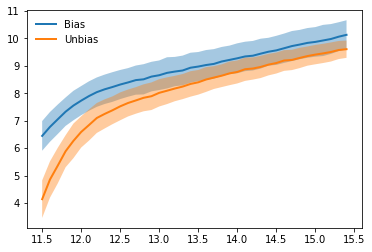

In [152]:
#create a 2d array such that
#[[10...10]
#[11...11]
#...
#[14...14]
#[15...15]]
#process then take means/std along axis 1
N = 1000
DM = np.array([[i/10 for j in range(N)]for i in range(115, 155, 1)]) #Mhalo [Msun]


#Halo to stellar
M10, SHMnorm10, beta10, gamma10,M11,SHMnorm11,beta11,gamma11, Scatter = 11.925, 0.032,1.639,0.532,0.576,-0.014,-0.693,0.03,0.15
z = 0.1
zparameter = np.divide(z-0.1, z+1)
#putting the parameters together for inclusion in the Moster 2010 equation
M = M10 + M11*zparameter
N = SHMnorm10 + SHMnorm11*zparameter
b = beta10 + beta11*zparameter
g = gamma10 + gamma11*zparameter

SM = np.log10(np.power(10, DM) * (2*N*np.power( (np.power(np.power(10,DM-M), -b) + np.power(np.power(10,DM-M), g)), -1))) + np.random.normal(0, Scatter, size = np.shape(DM))


#Stellar to BH
BH_bias = Ms_to_Mbh_biased(SM)
BH_unbi = Ms_to_Mbh_intrisic(SM)


#plt.errorbar(np.mean(DM, axis = 1), np.mean(BH_bias, axis = 1), np.std(BH_bias, axis = 1), label = "Bias")
#plt.errorbar(np.mean(DM, axis = 1), np.mean(BH_unbi, axis = 1), np.std(BH_unbi, axis = 1), label = "Unbias")


plt.plot(np.mean(DM, axis = 1), np.mean(BH_bias, axis = 1), label = "Bias")
plt.plot(np.mean(DM, axis = 1), np.mean(BH_unbi, axis = 1), label = "Unbias")

plt.fill_between(np.mean(DM, axis = 1), y1 = np.mean(BH_bias, axis = 1) - np.std(BH_bias, axis = 1),\
                 y2=np.mean(BH_bias, axis = 1) + np.std(BH_bias, axis = 1), alpha = 0.4)
plt.fill_between(np.mean(DM, axis = 1), y1 = np.mean(BH_unbi, axis = 1) - np.std(BH_unbi, axis = 1),\
                 y2=np.mean(BH_unbi, axis = 1) + np.std(BH_unbi, axis = 1), alpha = 0.4)

plt.legend(frameon = False)
plt.show()

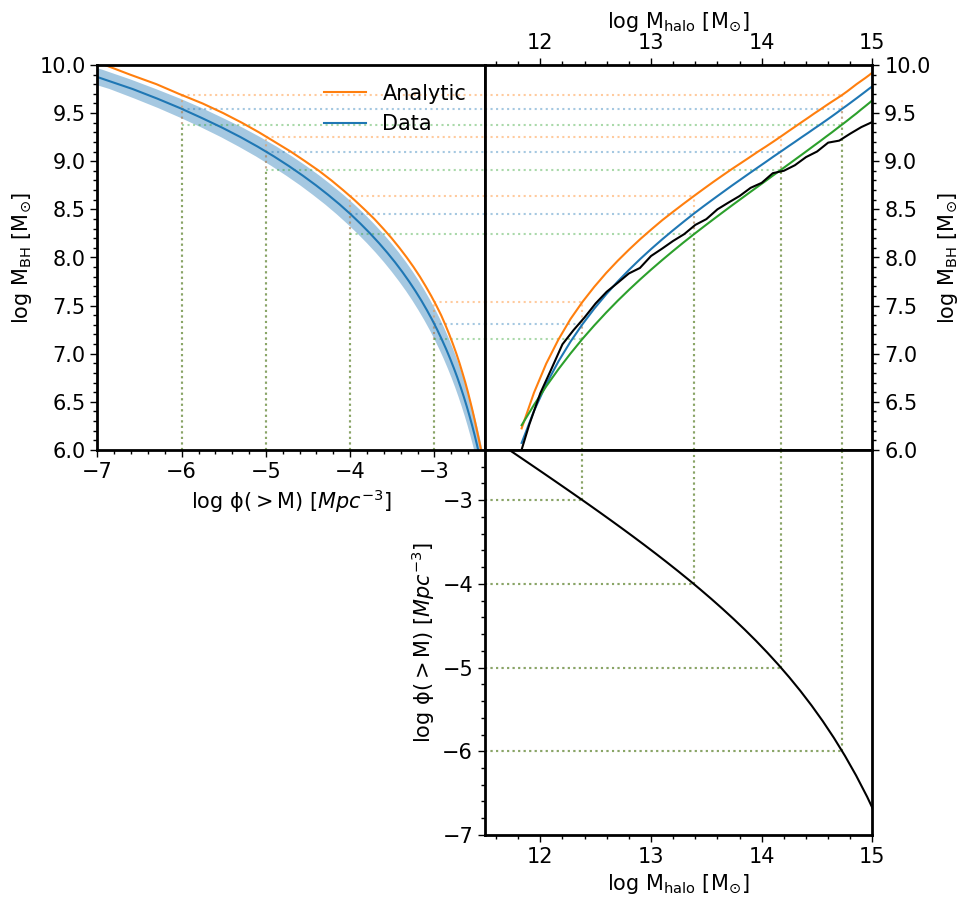

In [266]:
#set up ABN Corner plot
fig = plt.figure(figsize=[10,10])
gs = GridSpec(10, 10, hspace=0.0,wspace=0.0,figure=fig)
ax1 = fig.add_subplot(gs[0:5,0:5])
ax2 = fig.add_subplot(gs[0:5,5:10])
ax3 = fig.add_subplot(gs[5:10,5:10])



#for the analytic BH mass function
BH_X = np.arange(5, 12, 0.1)
ax1.plot(np.log10(np.flip(np.cumsum(np.flip(BH_Y_Intr)))), BH_X, label = "Analytic", color = "C1") #Analytic

#the data BH mass function
BH_MF_Data = np.loadtxt(AbsPath+"/Data/Observational/Francesco/BHmassFunction.txt", skiprows = 2).T
ax1.plot(np.log10(np.flip(np.cumsum(np.flip(np.power(10,BH_MF_Data[1])*0.1)))), BH_MF_Data[0], label = "Data", color = "C0")
Upper = np.log10(np.flip(np.cumsum(np.flip(np.power(10,BH_MF_Data[1]+BH_MF_Data[2])*0.1))))
Lower = np.log10(np.flip(np.cumsum(np.flip(np.power(10,BH_MF_Data[1]-BH_MF_Data[2])*0.1))))
ax1.fill_betweenx(BH_MF_Data[0], Upper, Lower, alpha = 0.4)

ax1.legend(frameon = False)

#pull subhalos from STEEL output and cnahne to m200
SubHalosByAcc = HMF_Class.SHMF_STEEL(0.104)
DM_Masses =massdefs.changeMassDefinitionCModel(np.power(10, SubHalosByAcc[0]), 0.1, "vir", "200m")[0]/h
CentralHalos = mass_function.massFunction(DM_Masses*h, 0.1, mdef = "200m", model = 'tinker08', q_out='dndlnM')*np.log(10) #h^3 Mpc^-3 dex-1
"""
for i, z in enumerate(SubHalosByAcc[2]):
    #print(z)
    Wt = SubHalosByAcc[1][i] #Phi/N [Mpc^-3 dex-1 h3]
    if i > 0:
        SubHalos = SubHalos+Wt
    else:
        SubHalos = Wt
        

ax3.plot(np.log10(DM_Masses), np.log10(np.flip(np.cumsum(np.flip(SubHalos*h_3*0.1)))))
ax3.plot(np.log10(DM_Masses), np.log10(np.flip(np.cumsum(np.flip((CentralHalos+SubHalos)*h_3*0.1)))))
"""
ax3.plot(np.log10(DM_Masses), np.log10(np.flip(np.cumsum(np.flip(CentralHalos*h_3*0.1)))), color = "k")
#TotalHaloWt = np.log10(np.flip(np.cumsum(np.flip((CentralHalos+SubHalos)*h_3*0.1)))) #This is now cumlative
TotalHaloWt = np.log10(np.flip(np.cumsum(np.flip((CentralHalos)*h_3*0.1)))) #This is now cumlative
TotalBHWt = np.log10(np.flip(np.cumsum(np.flip(np.power(10,BH_MF_Data[1])*0.1)))) #This is now cumlative
TotalBHWt_Upper = np.log10(np.flip(np.cumsum(np.flip(np.power(10,Upper)*0.1)))) #This is now cumlative
TotalBHWtAnalitic = np.log10(np.flip(np.cumsum(np.flip(BH_Y_Intr)))) #This is now cumlative

HaloInterp = interpolate.interp1d(TotalHaloWt, np.log10(DM_Masses))
BHInterp = interpolate.interp1d(TotalBHWt, BH_MF_Data[0])
BHInterp_Upper = interpolate.interp1d(TotalBHWt_Upper, BH_MF_Data[0])
BHInterp_Ana = interpolate.interp1d(TotalBHWtAnalitic, BH_X)

CumNumDenRange = np.arange(-7, -2.4, 0.1)

ax2.plot(HaloInterp(CumNumDenRange), BHInterp_Ana(CumNumDenRange), color = "C1")
ax2.plot(HaloInterp(CumNumDenRange), BHInterp(CumNumDenRange), color = "C0")
ax2.plot(HaloInterp(CumNumDenRange), BHInterp_Upper(CumNumDenRange), color = "C2")

Mh_u = 15.0
Mh_l = 11.5
Mbh_u = 10
Mbh_l = 6
ND_u = -2.4
ND_l = -7


#function to draw hlines/vlines
def LinePlotter(NumberDensity, HM_Interp, BH_Interp, Axis1, Axis2, Axis3, colour):
    HaloMass = HM_Interp(NumberDensity)
    BHMass = BH_Interp(NumberDensity)
    Axis1.hlines(BHMass, NumberDensity, ND_u, linestyle = ":", alpha = 0.4, color = colour)
    Axis1.vlines(NumberDensity, Mbh_l, BHMass, linestyle = ":", alpha = 0.4, color = colour)
    Axis2.hlines(BHMass, Mh_l, HaloMass, linestyle = ":", alpha = 0.4, color = colour)
    Axis2.vlines(HaloMass, Mbh_l, BHMass, linestyle = ":", alpha = 0.4, color = colour)
    Axis3.hlines(NumberDensity, Mh_l, HaloMass, linestyle = ":", alpha = 0.4, color = colour)
    Axis3.vlines(HaloMass, NumberDensity, ND_u, linestyle = ":", alpha = 0.4, color = colour)


for i in [-3, -4,-5,-6]:
    LinePlotter(i, HaloInterp, BHInterp, ax1, ax2, ax3, "C0")
    LinePlotter(i, HaloInterp, BHInterp_Ana, ax1, ax2, ax3, "C1")
    LinePlotter(i, HaloInterp, BHInterp_Upper, ax1, ax2, ax3, "C2")


#Set axis limits
ax1.set_xlim(ND_l,ND_u)
ax1.set_ylim(Mbh_l, Mbh_u)

ax2.set_ylim(Mbh_l, Mbh_u)
ax2.set_xlim(Mh_l,Mh_u)

ax3.set_xlim(Mh_l,Mh_u)
ax3.set_ylim(ND_l,ND_u)


ax2.plot(np.mean(DM, axis = 1), np.mean(BH_unbi, axis = 1), label = "Unbias", color = "k")

ax2.yaxis.tick_right()
ax2.xaxis.tick_top()
ax2.xaxis.set_label_position("top")
ax2.yaxis.set_label_position("right")


#set axis titles
ax1.set_ylabel(r"log $\mathrm{M_{BH}}$ $\mathrm{[M_{\odot}]}$")
ax1.set_xlabel(r"log $\mathrm{\phi(>M)}$ $[Mpc^{-3}]$")
ax2.set_ylabel(r"log $\mathrm{M_{BH}}$ $\mathrm{[M_{\odot}]}$")
ax2.set_xlabel(r"log $\mathrm{M_{halo}}$ $\mathrm{[M_{\odot}]}$")
ax3.set_xlabel(r"log $\mathrm{M_{halo}}$ $\mathrm{[M_{\odot}]}$")
ax3.set_ylabel(r"log $\mathrm{\phi(>M)}$ $[Mpc^{-3}]$")
plt.show()

FS wants the unevolved surviving subhalo mass function for a log Mhalo = 13 @ z = 0.25

and

The unevolved surviving subhalo mass sunctions of satelitees with 13.3 < log Mhalo < 13.7

In [271]:
#load the Surviving subhalos by parent array from steel in /Data/Model/Output/Other/
SubHaloes = np.load(AbsPath+"/Data/Model/Output/Other/SubHaloes/Surviving_Subhalos_ByParent1.0.npy")
#This has dimentions a,b,c from steel which are redhsift central mass subhalo mass
#We load this for z, avahalomass, sathalomass the other two arrays are not used
Pair_Frac_Halo, Accretion_History_Halo, z, AvaHaloMass, SatHaloMass = F.LoadData_Pair_Frac_Halo(('1.0', True, True, True, 'G19_DPL', 'G19_SE'))

In [282]:
z_bin = np.digitize(0.25, bins = z)
M_bin = np.digitize(13, bins = AvaHaloMass[z_bin])
M_bin_l, M_bin_u = np.digitize([13.3, 13.7], bins = AvaHaloMass[z_bin])
M_sat_bin_l, M_sat_bin_u = np.digitize([13.3, 13.7], bins = SatHaloMass)

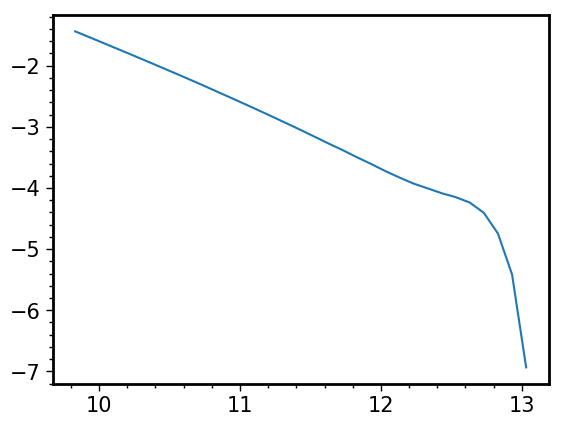

In [287]:
usSHMF_13 = SubHaloes[z_bin, M_bin]
np.savetxt("FileA.txt", np.vstack((SatHaloMass, np.log10(usSHMF_13))))
plt.plot(SatHaloMass, np.log10(usSHMF_13))
plt.show()

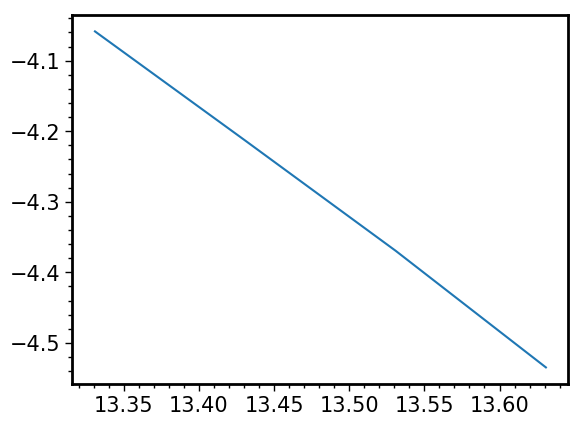

In [288]:
usSHMF_range = SubHaloes[z_bin,:,M_sat_bin_l:M_sat_bin_u]
np.savetxt("FileB.txt", np.vstack((SatHaloMass[M_sat_bin_l:M_sat_bin_u], np.log10(np.sum(usSHMF_range, axis = 0)))))
plt.plot(SatHaloMass[M_sat_bin_l:M_sat_bin_u], np.log10(np.sum(usSHMF_range, axis = 0)))
plt.show()

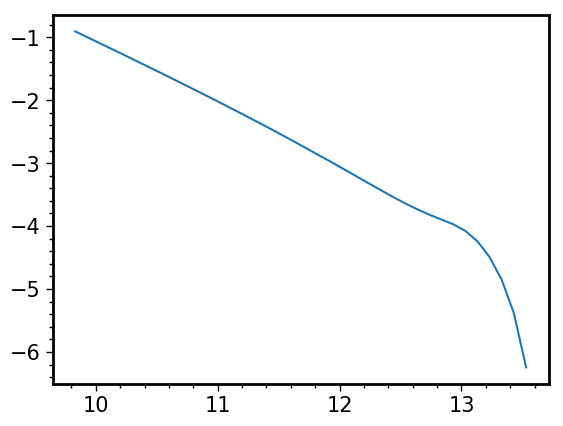

In [289]:
usSHMF_range = SubHaloes[z_bin,M_bin_l:M_bin_u]
np.savetxt("FileC.txt", np.vstack((SatHaloMass, np.log10(np.sum(usSHMF_range, axis = 0)))))
plt.plot(SatHaloMass, np.log10(np.sum(usSHMF_range, axis = 0)))
plt.show()